In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Import the required modules for webacm
import cv2
from IPython.display import clear_output
import time
import PIL.Image
from io import BytesIO as StringIO
import IPython.display

In [2]:
import torch
from models import NaimishNet, resnet18_grayscale,res18_modd

img_size = 224

#net = NaimishNet(image_size=img_size, kernels=[5, 5, 5, 5], use_maxp=False)
net = resnet18_grayscale()


net.load_state_dict(torch.load('saved_models/resnet18_gray_epochs65_bs64_vloss0.00491.pt'))

# print out net
net.eval()

resnet18_grayscale(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

In [4]:
def detect_faces(img):
    
    faces = face_cascade.detectMultiScale(img, 1.2, 2)
    
    # make a copy of the original image to plot detections on
    image_with_detections = img.copy()
        
    for (x,y,w,h) in faces:
        # draw a rectangle around each detected face
        # you may also need to change the width of the rectangle drawn depending on image resolution
        cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0), 3) 

    return image_with_detections

In [5]:
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    
    #flip image for natural viewing
    frame = cv2.flip(frame, 1)
    
    return frame

In [6]:
device = torch.device('cuda')
net.to(device)
def detect_keypoints(img):
    
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    # faces=face_cascade.detectMultiScale(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    # print(len(faces))
    if len(faces) == 0:
        return img
    
    img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # loop over the detected faces from your haar cascade
    for (x,y,h,w) in faces:
        roi=img[y:y+h,x:x+w]
        roi = cv2.resize(cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY),(224,224))/255**2
        input_tensor = torch.from_numpy(roi).view(1,1,224,224).float().to(device)
        pts = net(input_tensor)
        pts = pts.view(68, -1)
        pts = pts.cpu().detach().numpy()   
        pts = pts*224/4+224/2
        # pts = pts*50+100
        
        scaler=np.array([w/224,h/224])

        scaled_pts=np.int32(pts*scaler+[x,y])
        # plt.scatter(scaled_pts[:,0], scaled_pts[:,1], s=10, c='r')
        # for pt in scaled_pts:
        #     # cv2.circle(img,(int(pt[0]),int(pt[1])),2,(0,255,0),-1)
        #     cv2.circle(img, pt, 6, (0, 0, 255), -1,)
        color = (0,255,0)
        
        for i in range(len(scaled_pts)):
            if (i != 16 and i != 21 and i != 26 and i != 30 and i != 35 and i < 68) :
                pt1 = (scaled_pts[i][0], scaled_pts[i][1])
                
                if i == 17:
                    # left eyebrow
                    color = (0,100,0)
                elif i == 22:
                    # right eyebrow
                    color = (0,100,0)
                elif i == 27:
                    # nose stem
                    color = (255,255,0)
                elif i == 31:
                    # nose tip
                    color = (255,255,0)
                elif i == 36:
                    # left eye
                    color = (0,250,154)
                elif i == 42:
                    # right eye
                    color = (0,250,154)
                elif i == 48:
                    # lips
                    color = (255,20,147)
                     
                if i == 41:
                    pt2 = (scaled_pts[36][0], scaled_pts[36][1])
                elif i == 47:
                    pt2 = (scaled_pts[42][0], scaled_pts[42][1])
                elif i == 67:
                    pt2 = (scaled_pts[60][0], scaled_pts[60][1])
                else:
                    pt2 = (scaled_pts[i+1][0], scaled_pts[i+1][1])
                    
                cv2.line(img, pt1, pt2, color, thickness=5, lineType=8, shift=0) 
                
            
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
img = plt.imread('./images/obamas.jpg')

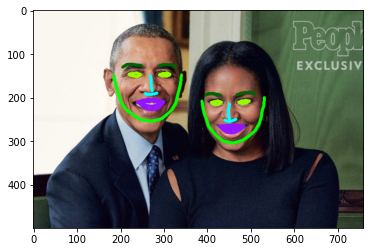

In [8]:
plt.imshow(detect_keypoints(img))

In [11]:
import cv2


# Connects to your computer's default camera
cap = cv2.VideoCapture(0)


# Automatically grab width and height from video feed
# (returns float which we need to convert to integer for later on!)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer = cv2.VideoWriter('student_capture.mp4', cv2.VideoWriter_fourcc(*'VIDX'),25, (width, height))

while True:
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)

    # Our operations on the frame come here
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = detect_keypoints(frame)#*([height/224, width/224])
    faces=face_cascade.detectMultiScale(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY), 1.3, 5)
    for (x,y,w,h) in faces:
        frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

    # Display the resulting frame
    writer.write(frame)
    cv2.imshow('frame',frame)
    
    # This command let's us quit with the "q" button on a keyboard.
    # Simply pressing X on the window won't work!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture and destroy the windows
cap.release()
writer.release()
cv2.destroyAllWindows()

In [10]:
img=plt.imread('../final2.jpg')

FileNotFoundError: [Errno 2] No such file or directory: '../final2.jpg'

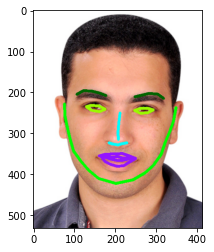

In [ ]:
plt.imshow(detect_keypoints(img))

In [ ]:
faces=face_cascade.detectMultiScale(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

In [ ]:
x,y,h,w=faces[0]

In [ ]:
roi=img[y:y+h,x:x+w]

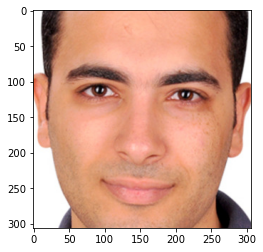

In [ ]:
plt.imshow(roi)

In [ ]:
roi.shape

(306, 306, 3)

In [ ]:
roi_copy=roi.copy()
roi_copy=cv2.resize(cv2.cvtColor(roi_copy, cv2.COLOR_RGB2GRAY),(224,224))/255**2

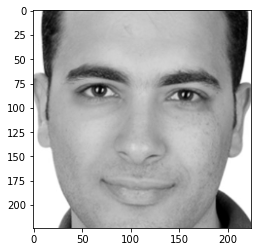

In [ ]:
plt.imshow(roi_copy,'gray')

In [ ]:
pts=net(torch.from_numpy(roi_copy).view(1,1,224,224).float().to(device))

In [ ]:
pts = pts.view(68, -1)
pts = pts.cpu().detach().numpy()   
pts = pts*224/4+224/2

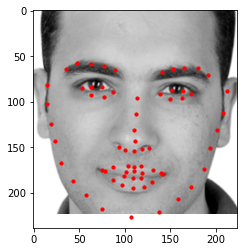

In [ ]:
plt.imshow(roi_copy,'gray')
plt.scatter(pts[:,0],pts[:,1],s=10,c='r')

In [ ]:
scale=np.array([w/224,h/224])

In [ ]:
scaled_pts=pts*scale+[x,y]

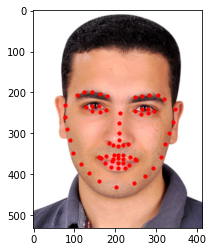

In [ ]:
plt.imshow(img,'gray')
plt.scatter(scaled_pts[:,0],scaled_pts[:,1],s=10,c='r')

In [ ]:
x,y,

(57, 120)